In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-130-us-hospitals-for-years-1999-2008/diabetic.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from joblib import dump, load
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:

print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [4]:
data = pd.read_csv("/kaggle/input/diabetes-130-us-hospitals-for-years-1999-2008/diabetic.csv")

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

In [6]:
check_df(data)

##################### Shape #####################
(101766, 50)
##################### Types #####################
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide 

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]

    #cat_but_car
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car


def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):
    if batch_size is None:
        batch_size = len(X_train)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    return train_dataset, val_dataset

def plot_training_history(history,train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):
    # Loss grafiği
    plt.figure(figsize=(12, 5))
    plt.plot(history.history[train_loss], label='Eğitim Loss', marker='o')
    plt.plot(history.history[val_loss], label='Doğrulama Loss', marker='o')
    plt.title('Eğitim ve Doğrulama Kayıp Değerleri')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy grafiği
    if 'accuracy' in history.history:
        plt.figure(figsize=(12, 5))
        plt.plot(history.history[train_metric], label='Eğitim Accuracy', marker='o')
        plt.plot(history.history[val_metric], label='Doğrulama Accuracy', marker='o')
        plt.title('Eğitim ve Doğrulama Doğruluk Değerleri')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

def get_best_epoch_details(history, metric="val_loss", mode=min):
    metric_values = history.history[metric]
    min_metric_value_index = metric_values.index(mode(metric_values))
    best_epoch = min_metric_value_index + 1

    metrics = []
    values = []

    for key, value in history.history.items():
        metrics.append(key)
        values.append(value[min_metric_value_index])

    data = {'Metric': metrics, 'Value': values}
    df = pd.DataFrame(data)
    df['Value'] = df['Value'].map('{:.4f}'.format)
    best_epoch_data = pd.DataFrame({'Metric': ['best_epoch'], 'Value': [str(best_epoch)]})
    df = pd.concat([df, best_epoch_data], ignore_index=True)
    return df

def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)

In [8]:


def dataproprocessing(data):

    cat_cols, num_cols, cat_but_car = grab_col_names(data)

    data=data.drop(columns=["encounter_id","patient_nbr","weight","medical_specialty","payer_code",
                            "chlorpropamide","acetohexamide","tolbutamide","acarbose","miglitol","troglitazone",
                            "tolazamide","examide","citoglipton","glyburide-metformin","glipizide-metformin",
                            "glimepiride-pioglitazone","metformin-rosiglitazone","metformin-pioglitazone","diabetesMed"])

    
    ageorder=["[0-10)","[10-20)","[20-30)","[30-40)","[40-50)","[60-70)","[70-80)","[80-90)","[90-100)"]
    oeage=OrdinalEncoder(categories=[ageorder],
                    handle_unknown="use_encoded_value",
                    unknown_value=-1)
    age_level=data["age"].values.reshape(-1,1)
    data["age"]=oeage.fit_transform(age_level)
    #Gender kısmındaki ? kısımlarının doldurulması
    impgender=data["gender"].mode()[0]
    data["gender"]=data["gender"].replace("Unknown/Invalid",impgender)
    data["gender"].value_counts()

    #Race kısmındaki ? kısımlarının doldurulması

    imprace=data["race"].mode()[0]
    data["race"]=data["race"].replace("?",imprace)
    data["race"].value_counts()

    # Max_glu_serum kısmının 0-1-2-3 ile ifade edilmesi
    data["max_glu_serum"]=data["max_glu_serum"].apply(lambda x: 3 if x==">300"
                                                 else( 2 if x==">200"
                                                 else( 1 if x=="Norm"
                                                 else 0 )))

    # a1cresult 
    data["A1Cresult"]=data["A1Cresult"].apply(lambda x: 1 if x=="Norm"
                                         else (2 if x==">7"
                                         else (3 if x==">8"
                                              else 0)))
    data["A1Cresult"].value_counts()

    #hedef değişkeni ayarlama
    data["readmitted"]=data["readmitted"].apply(lambda x: 1 if x=="NO" or x==">30"
                                           else 0)
    data["readmitted"].value_counts()
    

    #diag kısımlarını ayarlama
    data.loc[data['diag_1'].str.contains('V', na=False, case=False), 'diag_1'] = 0
    data.loc[data['diag_1'].str.contains('E', na=False, case=False), 'diag_1'] = 0
    data.loc[data['diag_2'].str.contains('V', na=False, case=False), 'diag_2'] = 0
    data.loc[data['diag_2'].str.contains('E', na=False, case=False), 'diag_2'] = 0
    data.loc[data['diag_3'].str.contains('V', na=False, case=False), 'diag_3'] = 0
    data.loc[data['diag_3'].str.contains('E', na=False, case=False), 'diag_3'] = 0

    # Eksik olan değerler yerine -1 yaz
    data['diag_1'] = data['diag_1'].replace('?', -1)
    data['diag_2'] = data['diag_2'].replace('?', -1)
    data['diag_3'] = data['diag_3'].replace('?', -1)

    # Sayısal değere dönüştür
    data['diag_1'] = data['diag_1'].astype(float)
    data['diag_2'] = data['diag_2'].astype(float)
    data['diag_3'] = data['diag_3'].astype(float)

    data.loc[(data['diag_1'] >= 1) & (data['diag_1'] < 140), 'diag_1'] = 1
    data.loc[(data['diag_1'] >= 140) & (data['diag_1'] < 240), 'diag_1'] = 2
    data.loc[(data['diag_1'] >= 240) & (data['diag_1'] < 280), 'diag_1'] = 3
    data.loc[(data['diag_1'] >= 280) & (data['diag_1'] < 290), 'diag_1'] = 4
    data.loc[(data['diag_1'] >= 290) & (data['diag_1'] < 320), 'diag_1'] = 5
    data.loc[(data['diag_1'] >= 320) & (data['diag_1'] < 390), 'diag_1'] = 6
    data.loc[(data['diag_1'] >= 390) & (data['diag_1'] < 460), 'diag_1'] = 7
    data.loc[(data['diag_1'] >= 460) & (data['diag_1'] < 520), 'diag_1'] = 8
    data.loc[(data['diag_1'] >= 520) & (data['diag_1'] < 580), 'diag_1'] = 9
    data.loc[(data['diag_1'] >= 580) & (data['diag_1'] < 630), 'diag_1'] = 10
    data.loc[(data['diag_1'] >= 630) & (data['diag_1'] < 680), 'diag_1'] = 11
    data.loc[(data['diag_1'] >= 680) & (data['diag_1'] < 710), 'diag_1'] = 12
    data.loc[(data['diag_1'] >= 710) & (data['diag_1'] < 740), 'diag_1'] = 13
    data.loc[(data['diag_1'] >= 740) & (data['diag_1'] < 760), 'diag_1'] = 14
    data.loc[(data['diag_1'] >= 760) & (data['diag_1'] < 780), 'diag_1'] = 15
    data.loc[(data['diag_1'] >= 780) & (data['diag_1'] < 800), 'diag_1'] = 16
    data.loc[(data['diag_1'] >= 800) & (data['diag_1'] < 1000), 'diag_1'] = 17
    data.loc[data['diag_1'] == -1, 'diag_1'] = 0

    data.loc[(data['diag_2'] >= 1) & (data['diag_2'] < 140), 'diag_2'] = 1
    data.loc[(data['diag_2'] >= 140) & (data['diag_2'] < 240), 'diag_2'] = 2
    data.loc[(data['diag_2'] >= 240) & (data['diag_2'] < 280), 'diag_2'] = 3
    data.loc[(data['diag_2'] >= 280) & (data['diag_2'] < 290), 'diag_2'] = 4
    data.loc[(data['diag_2'] >= 290) & (data['diag_2'] < 320), 'diag_2'] = 5
    data.loc[(data['diag_2'] >= 320) & (data['diag_2'] < 390), 'diag_2'] = 6
    data.loc[(data['diag_2'] >= 390) & (data['diag_2'] < 460), 'diag_2'] = 7
    data.loc[(data['diag_2'] >= 460) & (data['diag_2'] < 520), 'diag_2'] = 8
    data.loc[(data['diag_2'] >= 520) & (data['diag_2'] < 580), 'diag_2'] = 9
    data.loc[(data['diag_2'] >= 580) & (data['diag_2'] < 630), 'diag_2'] = 10
    data.loc[(data['diag_2'] >= 630) & (data['diag_2'] < 680), 'diag_2'] = 11
    data.loc[(data['diag_2'] >= 680) & (data['diag_2'] < 710), 'diag_2'] = 12
    data.loc[(data['diag_2'] >= 710) & (data['diag_2'] < 740), 'diag_2'] = 13
    data.loc[(data['diag_2'] >= 740) & (data['diag_2'] < 760), 'diag_2'] = 14
    data.loc[(data['diag_2'] >= 760) & (data['diag_2'] < 780), 'diag_2'] = 15
    data.loc[(data['diag_2'] >= 780) & (data['diag_2'] < 800), 'diag_2'] = 16
    data.loc[(data['diag_2'] >= 800) & (data['diag_2'] < 1000), 'diag_2'] = 17
    data.loc[data['diag_2'] == -1, 'diag_2'] = 0

    data.loc[(data['diag_3'] >= 1) & (data['diag_3'] < 140), 'diag_3'] = 1
    data.loc[(data['diag_3'] >= 140) & (data['diag_3'] < 240), 'diag_3'] = 2
    data.loc[(data['diag_3'] >= 240) & (data['diag_3'] < 280), 'diag_3'] = 3
    data.loc[(data['diag_3'] >= 280) & (data['diag_3'] < 290), 'diag_3'] = 4
    data.loc[(data['diag_3'] >= 290) & (data['diag_3'] < 320), 'diag_3'] = 5
    data.loc[(data['diag_3'] >= 320) & (data['diag_3'] < 390), 'diag_3'] = 6
    data.loc[(data['diag_3'] >= 390) & (data['diag_3'] < 460), 'diag_3'] = 7
    data.loc[(data['diag_3'] >= 460) & (data['diag_3'] < 520), 'diag_3'] = 8
    data.loc[(data['diag_3'] >= 520) & (data['diag_3'] < 580), 'diag_3'] = 9
    data.loc[(data['diag_3'] >= 580) & (data['diag_3'] < 630), 'diag_3'] = 10
    data.loc[(data['diag_3'] >= 630) & (data['diag_3'] < 680), 'diag_3'] = 11
    data.loc[(data['diag_3'] >= 680) & (data['diag_3'] < 710), 'diag_3'] = 12
    data.loc[(data['diag_3'] >= 710) & (data['diag_3'] < 740), 'diag_3'] = 13
    data.loc[(data['diag_3'] >= 740) & (data['diag_3'] < 760), 'diag_3'] = 14
    data.loc[(data['diag_3'] >= 760) & (data['diag_3'] < 780), 'diag_3'] = 15
    data.loc[(data['diag_3'] >= 780) & (data['diag_3'] < 800), 'diag_3'] = 16
    data.loc[(data['diag_3'] >= 800) & (data['diag_3'] < 1000), 'diag_3'] = 17
    data.loc[data['diag_3'] == -1, 'diag_3'] = 0

    
       

    cat_cols, num_cols, cat_but_car = grab_col_names(data)

    cat_cols.remove("readmitted")

    dataframe = pd.get_dummies(data, columns=cat_cols, drop_first=True, dtype=int)

    scaler = MinMaxScaler()

    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

    dump(scaler, 'scaler.joblib')

    

    y = dataframe["readmitted"]
    X = dataframe.drop(["readmitted"], axis=1)

    return X, y

In [9]:
X,y=dataproprocessing(data)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       101766 non-null  float64
 1   discharge_disposition_id  101766 non-null  float64
 2   admission_source_id       101766 non-null  float64
 3   time_in_hospital          101766 non-null  float64
 4   num_lab_procedures        101766 non-null  float64
 5   num_medications           101766 non-null  float64
 6   number_outpatient         101766 non-null  float64
 7   number_emergency          101766 non-null  float64
 8   number_inpatient          101766 non-null  float64
 9   diag_1                    101766 non-null  float64
 10  diag_2                    101766 non-null  float64
 11  diag_3                    101766 non-null  float64
 12  number_diagnoses          101766 non-null  float64
 13  race_Asian                101766 non-null  i

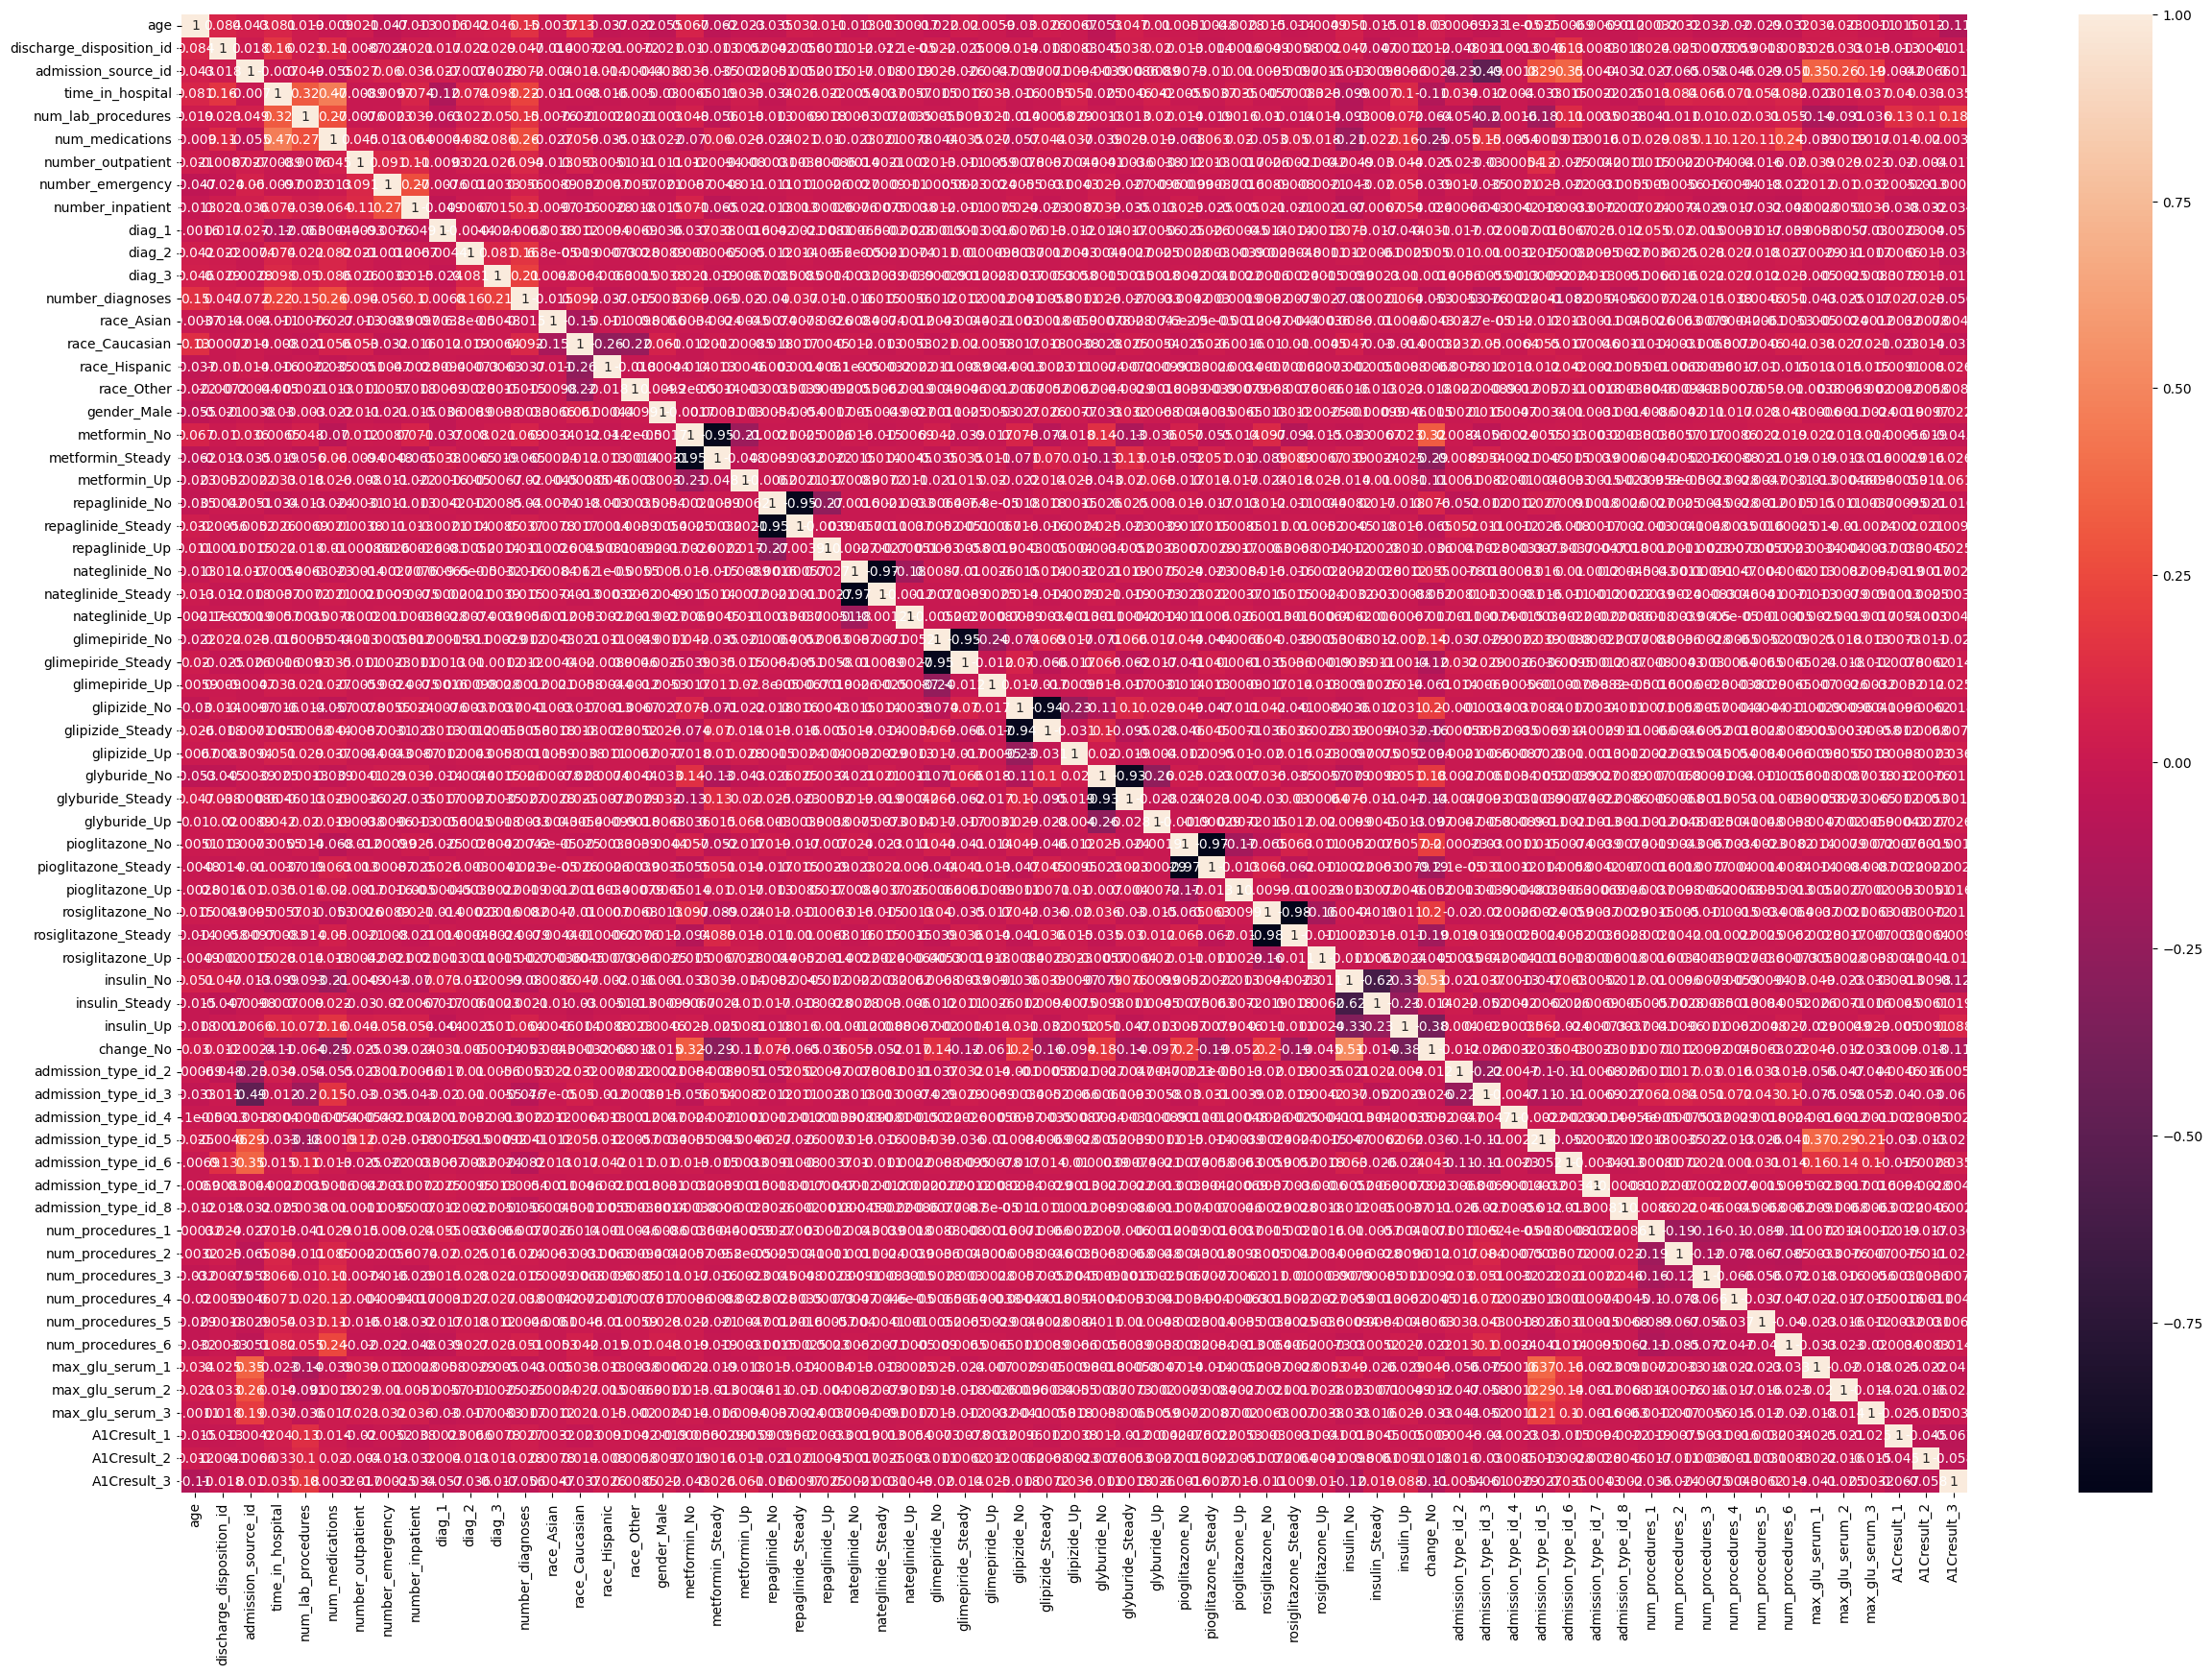

In [11]:
corr_matrix = X.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr_matrix, annot=True,color="red")
plt.show()

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Veri setini böl
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE uygula
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Orijinal eğitim verisi sınıf dağılımı:")
print(y_train.value_counts())
print("SMOTE sonrası eğitim verisi sınıf dağılımı:")
print(pd.Series(y_train_resampled).value_counts())

Orijinal eğitim verisi sınıf dağılımı:
readmitted
1    63304
0     7932
Name: count, dtype: int64
SMOTE sonrası eğitim verisi sınıf dağılımı:
readmitted
1    63304
0    63304
Name: count, dtype: int64


In [13]:
train_ds, val_ds = prepare_datasets(X_train_resampled, X_val, y_train_resampled, y_val, batch_size=32)

In [14]:
base_model = Sequential([

    Input(shape=(train_ds.element_spec[0].shape[1],)),
    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

optimizer = Adam(learning_rate=0.001)

base_model.compile(optimizer=optimizer,
                   loss="binary_crossentropy",
                   metrics=["accuracy", "precision", "recall", "auc"])

call_backs = EarlyStopping(monitor='val_auc',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True,
                               mode="max")

base_model_history = base_model.fit(train_ds,
                                    epochs=500,
                                    validation_data=val_ds,
                                    verbose=1,
                                    callbacks=call_backs)

Epoch 1/500
3957/3957 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5868 - auc: 0.6171 - loss: 0.7352 - precision: 0.5909 - recall: 0.5688 - val_accuracy: 0.7670 - val_auc: 0.6046 - val_loss: 0.5373 - val_precision: 0.9041 - val_recall: 0.8251
Epoch 2/500
3957/3957 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6429 - auc: 0.6975 - loss: 0.6418 - precision: 0.6540 - recall: 0.6136 - val_accuracy: 0.7223 - val_auc: 0.5961 - val_loss: 0.5607 - val_precision: 0.9051 - val_recall: 0.7678
Epoch 3/500
3957/3957 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6477 - auc: 0.7051 - loss: 0.6336 - precision: 0.6634 - recall: 0.6025 - val_accuracy: 0.5206 - val_auc: 0.6110 - val_loss: 0.7126 - val_precision: 0.9180 - val_recall: 0.5051
Epoch 4/500
3957/3957 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6496 - auc: 0.7072 - loss: 0.6318 - precision: 0.6671 - recall: 0.5993 - val_accuracy: 0.5405 - val_auc: 0.6142 - val_loss: 0.7010 - val_precision: 0.9187 - val_recall: 0.5293
Epoch 5/500
3957/39

In [15]:
get_best_epoch_details(base_model_history, metric="val_auc", mode=max)

,Metric,Value
0,accuracy,0.6588
1,auc,0.7149
2,loss,0.6278
3,precision,0.6755
4,recall,0.6113
5,val_accuracy,0.6061
6,val_auc,0.6231
7,val_loss,0.6599
8,val_precision,0.9178
9,val_recall,0.6110


In [16]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = base_model.evaluate(val_ds, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.6599153876304626
Validation Accuracy: 0.6060596108436584
Validation AUC: 0.6230655312538147
Validation Precision: 0.9178119897842407
Validation Recall: 0.610994279384613
Validation F1-Score: 0.7336153528643636


In [17]:
## Search Space
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(train_ds.element_spec[0].shape[1],)))

    # Hidden layers with advanced activation functions, l2, Dropout
    for i in range(hp.Int('num_layers', 1, 10)):
        # Add Dense layer
        model.add(Dense(
            units=hp.Int('units_' + str(i + 1), min_value=32, max_value=512, step=16),
            kernel_regularizer=l2(hp.Float('l2_' + str(i + 1), min_value=0.0001, max_value=0.01, sampling='log'))
        ))

        # Activation layer choice
        activation_choice = hp.Choice('activation_' + str(i + 1), values=['relu', 'leaky_relu', 'prelu'])

        if activation_choice == 'relu':
            model.add(ReLU())
        elif activation_choice == 'leaky_relu':
            model.add(LeakyReLU(negative_slope=0.01))
        elif activation_choice == 'prelu':
            model.add(PReLU())
        else:
            model.add(Activation(activation_choice))

        # Batch Normalization and Dropout
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i + 1), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Optimizer: Adam with tuning for beta1 and beta2
    optimizer = Adam(
        beta_1=hp.Float('beta1', min_value=0.85, max_value=0.99, step=0.01),
        beta_2=hp.Float('beta2', min_value=0.995, max_value=0.999, step=0.001)
    )

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy", "precision", "recall", "auc"])

    return model


In [18]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='max')

model_checkpoint = ModelCheckpoint(
    'final_tuned_model.keras',
    monitor='val_auc',
    verbose=0,
    save_best_only=True)

random_search_tuner.search(train_ds,
                           
                           epochs=100,

                           validation_data=val_ds,

                           callbacks=[early_stopping, model_checkpoint]
                          )

Trial 20 Complete [00h 16m 53s]
val_loss: 0.5887359380722046

Best val_loss So Far: 0.48880621790885925
Total elapsed time: 04h 57m 25s


In [19]:
def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)

In [20]:
best_model_ex = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
print_hyperparameters(best_model_ex.values)
dump(best_model_ex, 'best_model.joblib')
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_model.summary()

   Hyperparameter       Value
0      num_layers           6
1         units_1         336
2            l2_1     0.00217
3    activation_1       prelu
4       dropout_1     0.00000
5           beta1     0.85000
6           beta2     0.99500
7         units_2         256
8            l2_2     0.00020
9    activation_2        relu
10      dropout_2     0.30000
11        units_3         352
12           l2_3     0.00954
13   activation_3       prelu
14      dropout_3     0.00000
15        units_4         496
16           l2_4     0.00020
17   activation_4       prelu
18      dropout_4     0.40000
19        units_5         320
20           l2_5     0.00013
21   activation_5        relu
22      dropout_5     0.00000
23        units_6         160
24           l2_6     0.00057
25   activation_6  leaky_relu
26      dropout_6     0.30000
27        units_7          64
28           l2_7     0.00014
29   activation_7  leaky_relu
30      dropout_7     0.20000
31        units_8         112
32        

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 60 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 336)            │        22,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 336)            │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 336)            │         1,344 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        86,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 352)            │        90,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 352)            │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 352)            │         1,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 496)            │       175,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 496)            │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 496)            │         1,984 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 320)            │       159,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 593,425 (2.26 MB)

 Trainable params: 589,585 (2.25 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [21]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = best_model.evaluate(val_ds, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.48880621790885925
Validation Accuracy: 0.823845386505127
Validation AUC: 0.5997866988182068
Validation Precision: 0.8984704613685608
Validation Recall: 0.9037078022956848
Validation F1-Score: 0.901081521669316
